# Getting started with TensorFlow Decision Forests


**How to use this notebook**:
 - Click on the "copy & edit" button in the top right corner. Run the code cells from top to bottom and save a new version.
 - Read through and understand both the markdown cells as well as the code cells and their outputs.
 - Make a submission to the [Tabular Playground Series](https://www.kaggle.com/competitions/tabular-playground-series-may-2022) competition. Experiment and try to increase your score (model selection, hyperparameter choices, feature engineering, feature selection, etc)


# Introduction

The goal of this notebook is to help Kagglers to get started with the [TensorFlow Decision Forests (TF-DF)](https://www.tensorflow.org/decision_forests) Python API.  We will use data from the [Tabular Playground Series](https://www.kaggle.com/competitions/tabular-playground-series-may-2022/data) Kaggle competition to train ML models using TF-DF.

We'll be working with the [Tabular Playground Series May 2022](https://www.kaggle.com/competitions/tabular-playground-series-may-2022/data) Kaggle Dataset.  It is a tabular dataset with 900,000 rows and 33 columns (318MB .CSV training dataset + 247MB .CSV test set) that is suitable for training algorithms to solve binary classification problems (in this case to determine if a machine is in a state of "0" or "1" based off of input sensor data).  

We'll be using [TensorFlow Decision Forests](https://www.tensorflow.org/decision_forests) (TF-DF) to train our model.  TensorFlow Decision Forests is a TensorFlow wrapper for the [Yggdrasil Decision Forests C++ libraries](https://github.com/google/yggdrasil-decision-forests).  TF-DF makes it very easy to train, serve and interpret various Decision Forest models such as [RandomForests](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel) and [GrandientBoostedTrees](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/GradientBoostedTreesModel).  These types of decision forest models require minimal pre-processing of the data and are great when working with tabular datasets and/or small datasets (especially if you just want a quick baseline result to compare against).

By studying this tutorial you will learn how to quickly train a GradientBoostedTrees model to perform a binary classification task using tabular data.

Step 1: Import Python packages

In [1]:
!pip install tensorflow_decision_forests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.5/497.5 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.3
    Uninstalling tensorflow-2.6.3:

In [2]:
# Import Python packages
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_decision_forests as tfdf
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow Decision Forests v0.2.4


In [3]:
# Define helper functions:  
# One for plotting training evaluation curves, and another for expanding feature number 27.
# This bit of code is not particularly important with regards to learning how to use TensorFlow Decision Forests (TF-DF)
# If you are just trying to learn how to use TF-DF then my recommendation would be to skip this code cell and instead focus on understanding all the rest

def plot_tfdf_model_training_curves(model):
    # This function was adapted from the following tutorial:
    # https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
    logs = model.make_inspector().training_logs()
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    # Plot accuracy vs number of trees
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")
    plt.subplot(1, 2, 2)
    # Plot loss vs number of trees
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")
    plt.show()
    
    
def expand_feature_27(data):
    # This function was adapted from the following notebooks:
    # https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model and
    # https://www.kaggle.com/code/ambrosm/tpsmay22-gradient-boosting-quickstart
    for df in [data]:
        # Extract the 10 letters of f_27 into individual features
        for i in range(10):
            df[f'ch{i}'] = df.f_27.str.get(i).apply(ord) - ord('A')
        df["unique_characters"] = df.f_27.apply(lambda s: len(set(s)))
        # Feature interactions: create three ternary features
        # Every ternary feature can have the values -1, 0 and +1
        df['i_02_21'] = (df.f_21 + df.f_02 > 5.2).astype(int) - (df.f_21 + df.f_02 < -5.3).astype(int)
        df['i_05_22'] = (df.f_22 + df.f_05 > 5.1).astype(int) - (df.f_22 + df.f_05 < -5.4).astype(int)
        i_00_01_26 = df.f_00 + df.f_01 + df.f_26
        df['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)
        return data

Step 2: Identify the location of the data

In [4]:
# print list of all data and files attached to this notebook
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-may-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-may-2022/train.csv
/kaggle/input/tabular-playground-series-may-2022/test.csv


Step 3: Load the data

In [5]:
# load to pandas dataframe (for data exploration)
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-may-2022/train.csv')
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-may-2022/test.csv')

# load to tensorflow dataset (for model training)
train_tfds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="target")
test_tfds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

/opt/conda/lib/python3.7/site-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)
2022-05-13 18:36:35.632612: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-05-13 18:36:35.646898: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the 

Step 4: Explore the data

In [6]:
# print column names
print(train_df.columns)

Index(['id', 'f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06', 'f_07',
       'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16',
       'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25',
       'f_26', 'f_27', 'f_28', 'f_29', 'f_30', 'target'],
      dtype='object')


In [7]:
# preview first few rows of data
train_df.head(10)

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,...,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,...,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,...,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1
5,5,1.349785,1.100418,0.562612,-0.607076,1.264728,0.283515,-1.131953,6,2,...,-2.259781,-1.308329,-2.216110,1.016892,0.273792,BDAEDBDEDA,45.890998,0,1,0
6,6,1.904853,-0.174135,0.193908,-0.559832,-0.146990,-0.538386,0.270837,2,5,...,-2.832988,2.432185,-1.827240,1.192390,-0.333300,ACBCAAAHHE,358.058637,1,0,1
7,7,0.889100,0.388168,1.062274,-1.775401,0.852494,0.335741,0.510709,2,3,...,7.956038,2.663890,-0.593400,1.528621,0.972924,BBBDBBEPDB,-113.797366,1,1,0
8,8,0.866221,0.842351,-1.367634,1.237506,0.682962,0.845666,0.173852,3,2,...,-1.241121,-1.245038,1.696402,0.354545,-0.541267,ACAEBADDAA,-52.223857,0,0,0
9,9,0.829142,-0.082872,-0.206667,-0.032502,0.366289,0.277981,-1.113467,2,0,...,-3.117106,-3.609328,2.677487,-1.772600,-3.053609,BABCBBBABD,-42.976312,0,0,1


In [8]:
# print basic summary statistics
train_df.describe()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,target
count,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,...,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000,900000.000000
mean,449999.500000,-0.000286,0.001165,0.001174,-0.001368,-0.000571,0.000284,-0.000709,2.031460,2.057998,...,-0.156307,-0.009273,-0.369459,-0.342738,0.176549,0.357591,-0.380876,0.345661,1.002654,0.486488
std,259807.765473,0.998888,0.999193,1.000514,1.000175,1.000167,0.999875,0.999942,1.656172,1.590955,...,2.484706,2.450797,2.453405,2.386941,2.416959,2.476020,238.773054,0.475584,0.818989,0.499818
min,0.000000,-4.599856,-4.682199,-4.642676,-4.658816,-4.748501,-4.750214,-4.842919,0.000000,0.000000,...,-13.310146,-11.853530,-12.301097,-11.416189,-11.918306,-14.300577,-1229.753052,0.000000,0.000000,0.000000
25%,224999.750000,-0.675490,-0.675162,-0.674369,-0.676114,-0.675909,-0.673437,-0.674876,1.000000,1.000000,...,-1.820063,-1.645585,-2.019739,-1.955956,-1.440424,-1.261598,-159.427418,0.000000,0.000000,0.000000
50%,449999.500000,0.001144,0.002014,0.002218,-0.002227,-0.001662,-0.000438,-0.001492,2.000000,2.000000,...,-0.152668,0.030850,-0.390966,-0.340746,0.160912,0.404212,-0.519808,0.000000,1.000000,0.000000
75%,674999.250000,0.674337,0.675021,0.677505,0.672544,0.673789,0.675028,0.674749,3.000000,3.000000,...,1.507071,1.661676,1.255408,1.266673,1.795928,2.028219,158.987357,1.000000,2.000000,1.000000
max,899999.000000,4.749301,4.815699,4.961982,4.454920,4.948983,4.971881,4.822668,15.000000,16.000000,...,14.455426,11.344080,12.247100,12.389844,12.529179,12.913041,1229.562577,1.000000,2.000000,1.000000


<AxesSubplot:>

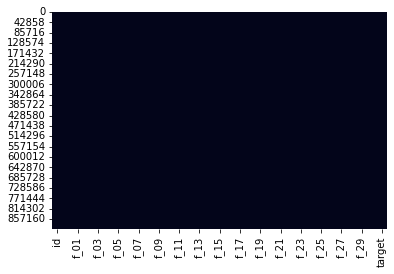

In [9]:
# check for missing values
sns.heatmap(train_df.isnull(), cbar=False)

Step 5: Feature Engineering

Here we just expand out feature number 27. There are 10 unique character positions in feature number 27, and the following bit of code expands feature 27 to instead be 10+ features instead of only one feature. Adding in this step boosts our score by >>5%.

In [10]:
print('Feature number 27 is a string') 
print('with 10 different character positions (1-10)') 
print('where each character position will contain')
print('one of 26 possible characters (A-Z):\n\n')
train_df[['f_27']].head()

Feature number 27 is a string
with 10 different character positions (1-10)
where each character position will contain
one of 26 possible characters (A-Z):




,f_27
0,ABABDADBAB
1,ACACCADCEB
2,AAAEABCKAD
3,BDBBAACBCB
4,BDBCBBCHFE


In [11]:
train_df = expand_feature_27(train_df)
test_df = expand_feature_27(test_df)
train_tfds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="target")
test_tfds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

/opt/conda/lib/python3.7/site-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [12]:
print('\n\nNew features split out from f_27:\n\n')
train_df[['f_27','ch0', 'ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7',
       'ch8', 'ch9', 'unique_characters', 'i_02_21', 'i_05_22',
       'i_00_01_26']].head()



New features split out from f_27:




,f_27,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,unique_characters,i_02_21,i_05_22,i_00_01_26
0,ABABDADBAB,0,1,0,1,3,0,3,1,0,1,3,0,0,0
1,ACACCADCEB,0,2,0,2,2,0,3,2,4,1,5,0,0,0
2,AAAEABCKAD,0,0,0,4,0,1,2,10,0,3,6,0,0,0
3,BDBBAACBCB,1,3,1,1,0,0,2,1,2,1,4,0,0,0
4,BDBCBBCHFE,1,3,1,2,1,1,2,7,5,4,6,0,0,1


To get to the top of the leaderboard you will likely want to do a lot more [feature engineering and feature selection](https://www.kaggle.com/learn/feature-engineering), as these steps were intentionally kept to a minimum in this tutorial (for the sake of brevity).

# RandomForest

Next we will take our training data and we will use it to train a Random Forest model (to predict whether a given piece of machinery is in a state of "0" or "1").

Step 6: Train a [Random Forest](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) Model



> "A Random Forest is a collection of deep CART decision trees trained independently and without pruning. Each tree is trained on a random subset of the original training dataset (sampled with replacement).
> 
> The algorithm is unique in that it is robust to overfitting, even in extreme cases e.g. when there is more features than training examples.
> 
> It is probably the most well-known of the Decision Forest training algorithms"




 ~ Quoted from [TFDF RandomForest documentation ](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel)

One neat thing about TF-DF is that in addition to having a default set of hyper-parameters, you are also provided with a list of additional hyper-parameter choices to consider.  This makes it a lot easier to optimize model performance because you do not have to do this expensive hyper-parameter optimization step all by yourself.

In [13]:
print(tfdf.keras.RandomForestModel.predefined_hyperparameters())

[HyperParameterTemplate(name='better_default', version=1, parameters={'winner_take_all': True}, description='A configuration that is generally better than the default parameters without being more expensive.'), HyperParameterTemplate(name='benchmark_rank1', version=1, parameters={'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')]


In [14]:
# Train the model
rf_model = tfdf.keras.RandomForestModel(hyperparameter_template="better_default")
rf_model.compile(metrics=[tf.keras.metrics.AUC(curve="ROC")]) 
rf_model.fit(x=train_tfds)

Resolve hyper-parameter template "better_default" to "better_default@v1" -> {'winner_take_all': True}.
Use /tmp/tmpq7h34tk8 as temporary training directory
Starting reading the dataset
899/900 [============================>.] - ETA: 0s
Dataset read in 0:00:38.246946
Training model
Model trained in 0:25:59.577203
Compiling model


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "RandomForestGeneric" built
[INFO kernel.cc:1001] Use fast generic engine


900/900 [==============================] - 1608s 2s/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [15]:
# Visualize the model
# Currently this step works in the Kaggle Notebook Editor but unfortunately displays an empty/blank visualization in the Notebook Viewer
tfdf.model_plotter.plot_model_in_colab(rf_model, tree_idx=0, max_depth=3)

Step 7: Evaluate your Random Forest Model

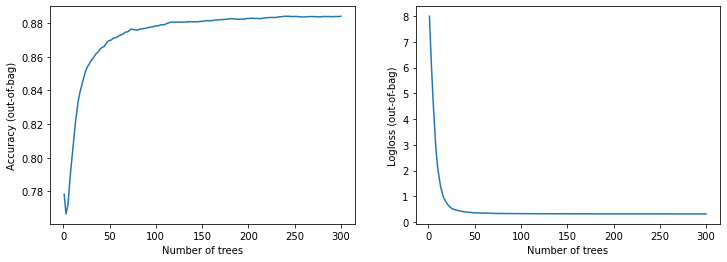

In [16]:
plot_tfdf_model_training_curves(rf_model)

In [17]:
inspector = rf_model.make_inspector()
inspector.evaluation()

Evaluation(num_examples=900000, accuracy=0.8840444444444444, loss=0.3223450269076394, rmse=None, ndcg=None, aucs=None)

In [18]:
rf_model.evaluate(train_tfds)

900/900 [==============================] - 120s 132ms/step - loss: 0.0000e+00 - auc: 0.9621


[0.0, 0.9621011018753052]

In [19]:
print("Model type:", inspector.model_type())
print("Objective:", inspector.objective())
print("Evaluation:", inspector.evaluation())

Model type: RANDOM_FOREST
Objective: Classification(label=__LABEL, class=None, num_classes=2)
Evaluation: Evaluation(num_examples=900000, accuracy=0.8840444444444444, loss=0.3223450269076394, rmse=None, ndcg=None, aucs=None)


90% accuracy is not a bad baseline result given how quickly we put this together (and with so few lines of code).

Step 8: Investigate variable importances for the RandomForest model


Variable importances (VI) describe the impact of each feature to the model.
 - > VIs generally indicates how much a variable contributes to the model predictions or quality. Different VIs have different semantics and are generally not comparable.
 - > The VIs returned by variable_importances() depends on the learning algorithm and its hyper-parameters. For example, the hyperparameter compute_oob_variable_importances=True of the Random Forest learner enables the computation of permutation out-of-bag variable importances.
 - > Variable importances can be obtained with tfdf.inspector.make_inspector(path).variable_importances().

The available variable importances are:
 - > Model agnostic
  - > MEAN_{INCREASE,DECREASE}_IN_{metric}: Estimated metric change from removing a feature using permutation importance . Depending on the learning algorithm and hyper-parameters, the VIs can be computed with validation, cross-validation or out-of-bag. For example, the MEAN_DECREASE_IN_ACCURACY of a feature is the drop in accuracy (the larger, the most important the feature) caused by shuffling the values of a features. For example, MEAN_DECREASE_IN_AUC_3_VS_OTHERS is the expected drop in AUC when comparing the label class "3" to the others.
 - > Decision Forests specific
  - > SUM_SCORE: Sum of the split scores using a specific feature. The larger, the most important.
  - > NUM_AS_ROOT: Number of root nodes using a specific feature. The larger, the most important.
  - > NUM_NODES: Number of nodes using a specific feature. The larger, the most important.
  - > MEAN_MIN_DEPTH: Average minimum depth of the first occurence of a feature across all the tree paths. The smaller, the most important.
  

~ Quoted from [TensorFlow Decision Forests](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/inspector/AbstractInspector#variable_importances) documentation and [yggdrasil-decision-forests](https://github.com/google/yggdrasil-decision-forests/blob/main/documentation/user_manual.md#variable-importances) documentation.


In [20]:
# Adapted from https://www.tensorflow.org/decision_forests/tutorials/advanced_colab
# See list of inspector methods from:
# [field for field in dir(inspector) if not field.startswith("_")]
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_AS_ROOT
	 SUM_SCORE
	 MEAN_MIN_DEPTH
	 NUM_NODES


Variable importances describe how each feature impacts the model. Here we can see that our 4 most important features were "unique_characters","i_00_01_26","i_02_21", and "i_05_22". We created these features during our feature engineering step and it looks like it made a big difference!

In [21]:
inspector.variable_importances()["SUM_SCORE"]

[("unique_characters" (1; #45), 8559961.985975528),
 ("i_00_01_26" (1; #41), 8515448.315656532),
 ("i_02_21" (1; #42), 5053855.080074244),
 ("i_05_22" (1; #43), 4598543.801122342),
 ("ch5" (1; #5), 2468369.840031034),
 ("ch9" (1; #9), 2060282.893772258),
 ("ch0" (1; #0), 2051836.7758154003),
 ("ch8" (1; #8), 2050253.435177054),
 ("f_29" (1; #39), 1946182.3513611706),
 ("ch4" (1; #4), 1937414.6749222507),
 ("f_21" (1; #31), 1897460.2807070962),
 ("f_07" (1; #17), 1578905.5031808524),
 ("ch1" (1; #1), 1561493.066251316),
 ("ch2" (1; #2), 1519906.467566439),
 ("f_10" (1; #20), 1462216.1779115282),
 ("f_08" (1; #18), 1411812.0346920758),
 ("f_26" (1; #36), 1341732.9562581587),
 ("ch3" (1; #3), 1311132.2550114477),
 ("f_22" (1; #32), 1289998.693153567),
 ("f_11" (1; #21), 1267783.753846785),
 ("f_30" (1; #40), 1207394.8679067558),
 ("ch7" (1; #7), 1203722.6598320992),
 ("f_14" (1; #24), 1041306.2690454304),
 ("f_19" (1; #29), 1028915.4390593584),
 ("f_24" (1; #34), 967343.0181240764),
 ("f_

# GradientBoostedTrees

Next we will take our training data and we will use it to train a Gradient Boosted model (to predict whether a given piece of machinery is in a state of "0" or "1").

Step 9: Train a [GradientBoostedTrees](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf) model.  GradientBoostedTrees often perform better than the RandomForests we were using previously.



> "A GBT (Gradient Boosted Tree) is a set of shallow decision trees trained sequentially. Each tree is trained to predict and then "correct" for the errors of the previously trained trees (more precisely each tree predict the gradient of the loss relative to the model output)"



 ~ Quoted from [TFDF GradientBoostedTrees documentation ](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/GradientBoostedTreesModel)


In [22]:
# As mentioned previously, TF-DF gives you lots of different "default" hyper-parameter settings to choose from.
print(tfdf.keras.GradientBoostedTreesModel.predefined_hyperparameters())

[HyperParameterTemplate(name='better_default', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL'}, description='A configuration that is generally better than the default parameters without being more expensive.'), HyperParameterTemplate(name='benchmark_rank1', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')]


In [23]:
# Train the model
gb_model = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1",num_trees=300)
gb_model.compile(metrics=[tf.keras.metrics.AUC(curve="ROC")])
gb_model.fit(x=train_tfds)

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmps1nxshud as temporary training directory
Starting reading the dataset
900/900 [==============================] - ETA: 0s
Dataset read in 0:00:33.062598
Training model
Model trained in 1:36:48.429468
Compiling model
900/900 [==============================] - 5842s 6s/step


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "GradientBoostedTreesGeneric" built
[INFO kernel.cc:1001] Use fast generic engine


In [24]:
# Visualize the model
# Currently this step works in the Kaggle Notebook Editor but unfortunately displays an empty/blank visualization in the Notebook Viewer
tfdf.model_plotter.plot_model_in_colab(gb_model, tree_idx=0, max_depth=3)

Step 10: Evaluate your GradientBoostedTrees  Model

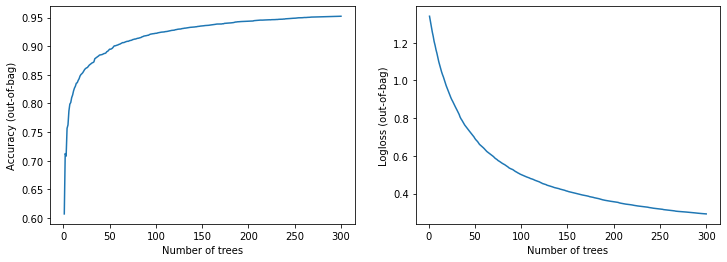

In [25]:
plot_tfdf_model_training_curves(gb_model)

In [26]:
inspector = gb_model.make_inspector()
inspector.evaluation()

Evaluation(num_examples=None, accuracy=0.9522895216941833, loss=0.292152464389801, rmse=None, ndcg=None, aucs=None)

In [27]:
gb_model.evaluate(train_tfds)

900/900 [==============================] - 57s 63ms/step - loss: 0.0000e+00 - auc_1: 0.9919


[0.0, 0.9918862581253052]

In [28]:
print("Model type:", inspector.model_type())
print("Objective:", inspector.objective())
print("Evaluation:", inspector.evaluation())

Model type: GRADIENT_BOOSTED_TREES
Objective: Classification(label=__LABEL, class=None, num_classes=2)
Evaluation: Evaluation(num_examples=None, accuracy=0.9522895216941833, loss=0.292152464389801, rmse=None, ndcg=None, aucs=None)


In [29]:
gb_model.evaluate(train_tfds)

900/900 [==============================] - 57s 63ms/step - loss: 0.0000e+00 - auc_1: 0.9919


[0.0, 0.9918862581253052]

95% accuracy is not a bad baseline result given how quickly we put this together (and with so few lines of code).

Step 10: Investigate variable importances for the GradientBoostedTrees model

As mentioned previously, variable importances describe how each feature impacts the model. Variable importances can tell you how much a given variable contributes to the model's predictions. 


In [30]:
# Adapted from https://www.tensorflow.org/decision_forests/tutorials/advanced_colab
# See list of inspector methods from:
# [field for field in dir(inspector) if not field.startswith("_")]
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES


Variable importances describe how each feature impacts the model. Once again we can see that our most important features were the features that we created during our feature engineering step. 

In [31]:
inspector.variable_importances()["SUM_SCORE"]

[("ch0" (1; #0), 74937.2862876237),
 ("unique_characters" (1; #45), 59880.92499381293),
 ("ch5" (1; #5), 56022.42360665841),
 ("i_00_01_26" (1; #41), 44965.57821086971),
 ("ch1" (1; #1), 40257.751509698515),
 ("ch3" (1; #3), 40216.232347002224),
 ("ch2" (1; #2), 37893.45239974107),
 ("ch8" (1; #8), 36752.47339416079),
 ("ch4" (1; #4), 34986.212706080856),
 ("ch9" (1; #9), 33166.364551833656),
 ("i_02_21" (1; #42), 29479.233640966246),
 ("f_07" (1; #17), 23927.089970445097),
 ("f_24" (1; #34), 21433.12581544393),
 ("i_05_22" (1; #43), 19029.476907398795),
 ("f_10" (1; #20), 19011.531955689967),
 ("f_02" (1; #12), 17985.74280155256),
 ("ch6" (1; #6), 17924.179332002732),
 ("ch7" (1; #7), 16906.38543383292),
 ("f_19" (1; #29), 16636.912173744415),
 ("f_26" (1; #36), 16546.608126598465),
 ("f_25" (1; #35), 13910.344194238445),
 ("f_22" (1; #32), 13080.126398635022),
 ("f_06" (1; #16), 11588.94788982276),
 ("f_15" (1; #25), 11115.19439010491),
 ("f_21" (1; #31), 10817.332587776184),
 ("f_29

In [32]:
tfdf.model_plotter.plot_model_in_colab(gb_model, tree_idx=0, max_depth=3)

Step 11: Submit your results

In [33]:
sample_submission_df = pd.read_csv('/kaggle/input/tabular-playground-series-may-2022/sample_submission.csv')
sample_submission_df['target'] = gb_model.predict(test_tfds)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

,id,target
0,900000,0.977072
1,900001,0.947126
2,900002,0.002395
3,900003,0.012140
4,900004,0.970120


TF-DF makes it very easy to find lots of useful information about your model.  For example, the following code cell provides a tremendous amount of information with just a single line of code.  You can preview the output of this code cell by clicking on the "show output" button below.

In [34]:
gb_model.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (46):
	ch0
	ch1
	ch2
	ch3
	ch4
	ch5
	ch6
	ch7
	ch8
	ch9
	f_00
	f_01
	f_02
	f_03
	f_04
	f_05
	f_06
	f_07
	f_08
	f_09
	f_10
	f_11
	f_12
	f_13
	f_14
	f_15
	f_16
	f_17
	f_18
	f_19
	f_20
	f_21
	f_22
	f_23
	f_24
	f_25
	f_26
	f_27
	f_28
	f_29
	f_30
	i_00_01_26
	i_02_21
	i_05_22
	id
	unique_characters

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.              "f_27"  5.349892 ################
    2.           "__LABEL"  5.349892 ################
    3.                "id"  5.349677 ###############
    4.              "f_29"  5.288925 ###############
    5.              "f_13"  5.279892 ###############
    6. 

# Conclusion

[TensorFlow Decision Forests](https://www.tensorflow.org/decision_forests) (TF-DF) made it  quick and easy to train our RandomForest and GradientBoostedTrees models.  These types of decision forest models require minimal pre-processing of the data and are great when working with tabular datasets and/or small datasets (especially if you just want a quick baseline result to compare against).  Some of my favorite parts about  working with TF-DF were: (1) I was able to train a GradientBoostedTrees model with only a few lines of code; (2) there were lots of different default hyper-parameter options that I could choose from; (3) it was easy to visualize the structure/architecture of my models; and (4) it was easy to explore what features were most important to my model (to interpret and explain its decisions).


We worked with the [Tabular Playground Series May 2022](https://www.kaggle.com/competitions/tabular-playground-series-may-2022/data) Kaggle Dataset.  It was a tabular dataset with 900,000 rows and 33 columns that contained data from industrial sensors, designed t be used to determine whether that piece of industrial equipment was in a state of  "0" or "1".

We were able to solve this task with an accuracy of ~95% which is not a bad baseline result given how quickly we were able to put this together (and with so few lines of code).

To learn more about TF-DF visit https://www.tensorflow.org/decision_forests.

Next steps?
 - Click on the "copy & edit" button in the top right corner of this notebook
 - Experiment and try to increase the score.  My recommendation would be to focus on the [feature engineering and feature selection](https://www.kaggle.com/learn/feature-engineering) steps, as these steps were omitted from this tutorial (for the sake of brevity)
 - Make a submission to https://www.kaggle.com/competitions/tabular-playground-series-may-2022

Works Cited:
 - [Build, train and evaluate models with TensorFlow Decision Forests](https://www.tensorflow.org/decision_forests/tutorials/beginner_colab) from @[tensorflow](https://www.tensorflow.org/decision_forests/tutorials/)
  - Code snippets for model training visualization 
  - See comments in plot_tfdf_model_training_curves() for more detail
 - [[TPS-MAY-22] EDA & LGBM Model](https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model) from @[cabaxiom](https://www.kaggle.com/cabaxiom)
  - Feature engineering code snippets
  - See comments in expand_feature_27() for more detail
 - [TPSMAY22 Gradient-Boosting Quickstart](https://www.kaggle.com/code/ambrosm/tpsmay22-gradient-boosting-quickstart) from @[ambrosm](https://www.kaggle.com/ambrosm)
  - Feature engineering code snippets
  - See comments in expand_feature_27() for more detail


Other Useful References:
 - https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
 - https://www.tensorflow.org/decision_forests/tutorials/intermediate_colab
 - https://www.tensorflow.org/decision_forests/tutorials/advanced_colab